In [16]:
import random

import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)
from scipy.signal import savgol_filter

from scipy import stats
import pickle


In [2]:
from shephard import interfaces
from shephard.apis import fasta

In [3]:
yeast_proteome = fasta.fasta_to_proteome('../figure_1/data/yeast_sequence_dataset.fasta',use_header_as_unique_ID=True)

In [4]:
interfaces.si_tracks.add_tracks_from_file(yeast_proteome,'../figure_1/data/conservation_scores_SHPRD.tsv', mode='values')
interfaces.si_tracks.add_tracks_from_file(yeast_proteome,'../figure_1/data/pLDDT_scores_SHPRD.tsv', mode='values')
interfaces.si_tracks.add_tracks_from_file(yeast_proteome,'../figure_1/data/disorder_scores_SHPRD.tsv', mode='values')
interfaces.si_domains.add_domains_from_file(yeast_proteome,'../figure_1/data/idrs_shephard.tsv')

interfaces.si_protein_attributes.add_protein_attributes_from_file(yeast_proteome,'../figure_1/data/number_of_orthologs_SHPRD.tsv')
interfaces.si_protein_attributes.add_protein_attributes_from_file(yeast_proteome,'../figure_1/data/essential_proteins_SHPRD.tsv')



## Proteome-wide ranked disorder
This analysis ranks the proteome by calculating the fraction of a protein that is disordered

In [5]:
fraction_disorder = []
for protein in yeast_proteome:
    f = np.sum([len(domain) for domain in protein.domains])/len(protein)
    fraction_disorder.append(f)

fraction_disorder = np.sort(fraction_disorder)[::-1]

In [6]:
total_protein=len(fraction_disorder)

In [7]:
idx_75 = np.argmin(np.absolute(fraction_disorder-0.75))
idx_50 = np.argmin(np.absolute(fraction_disorder-0.50))
idx_25 = np.argmin(np.absolute(fraction_disorder-0.25))
idx_10 = np.argmin(np.absolute(fraction_disorder-0.10))

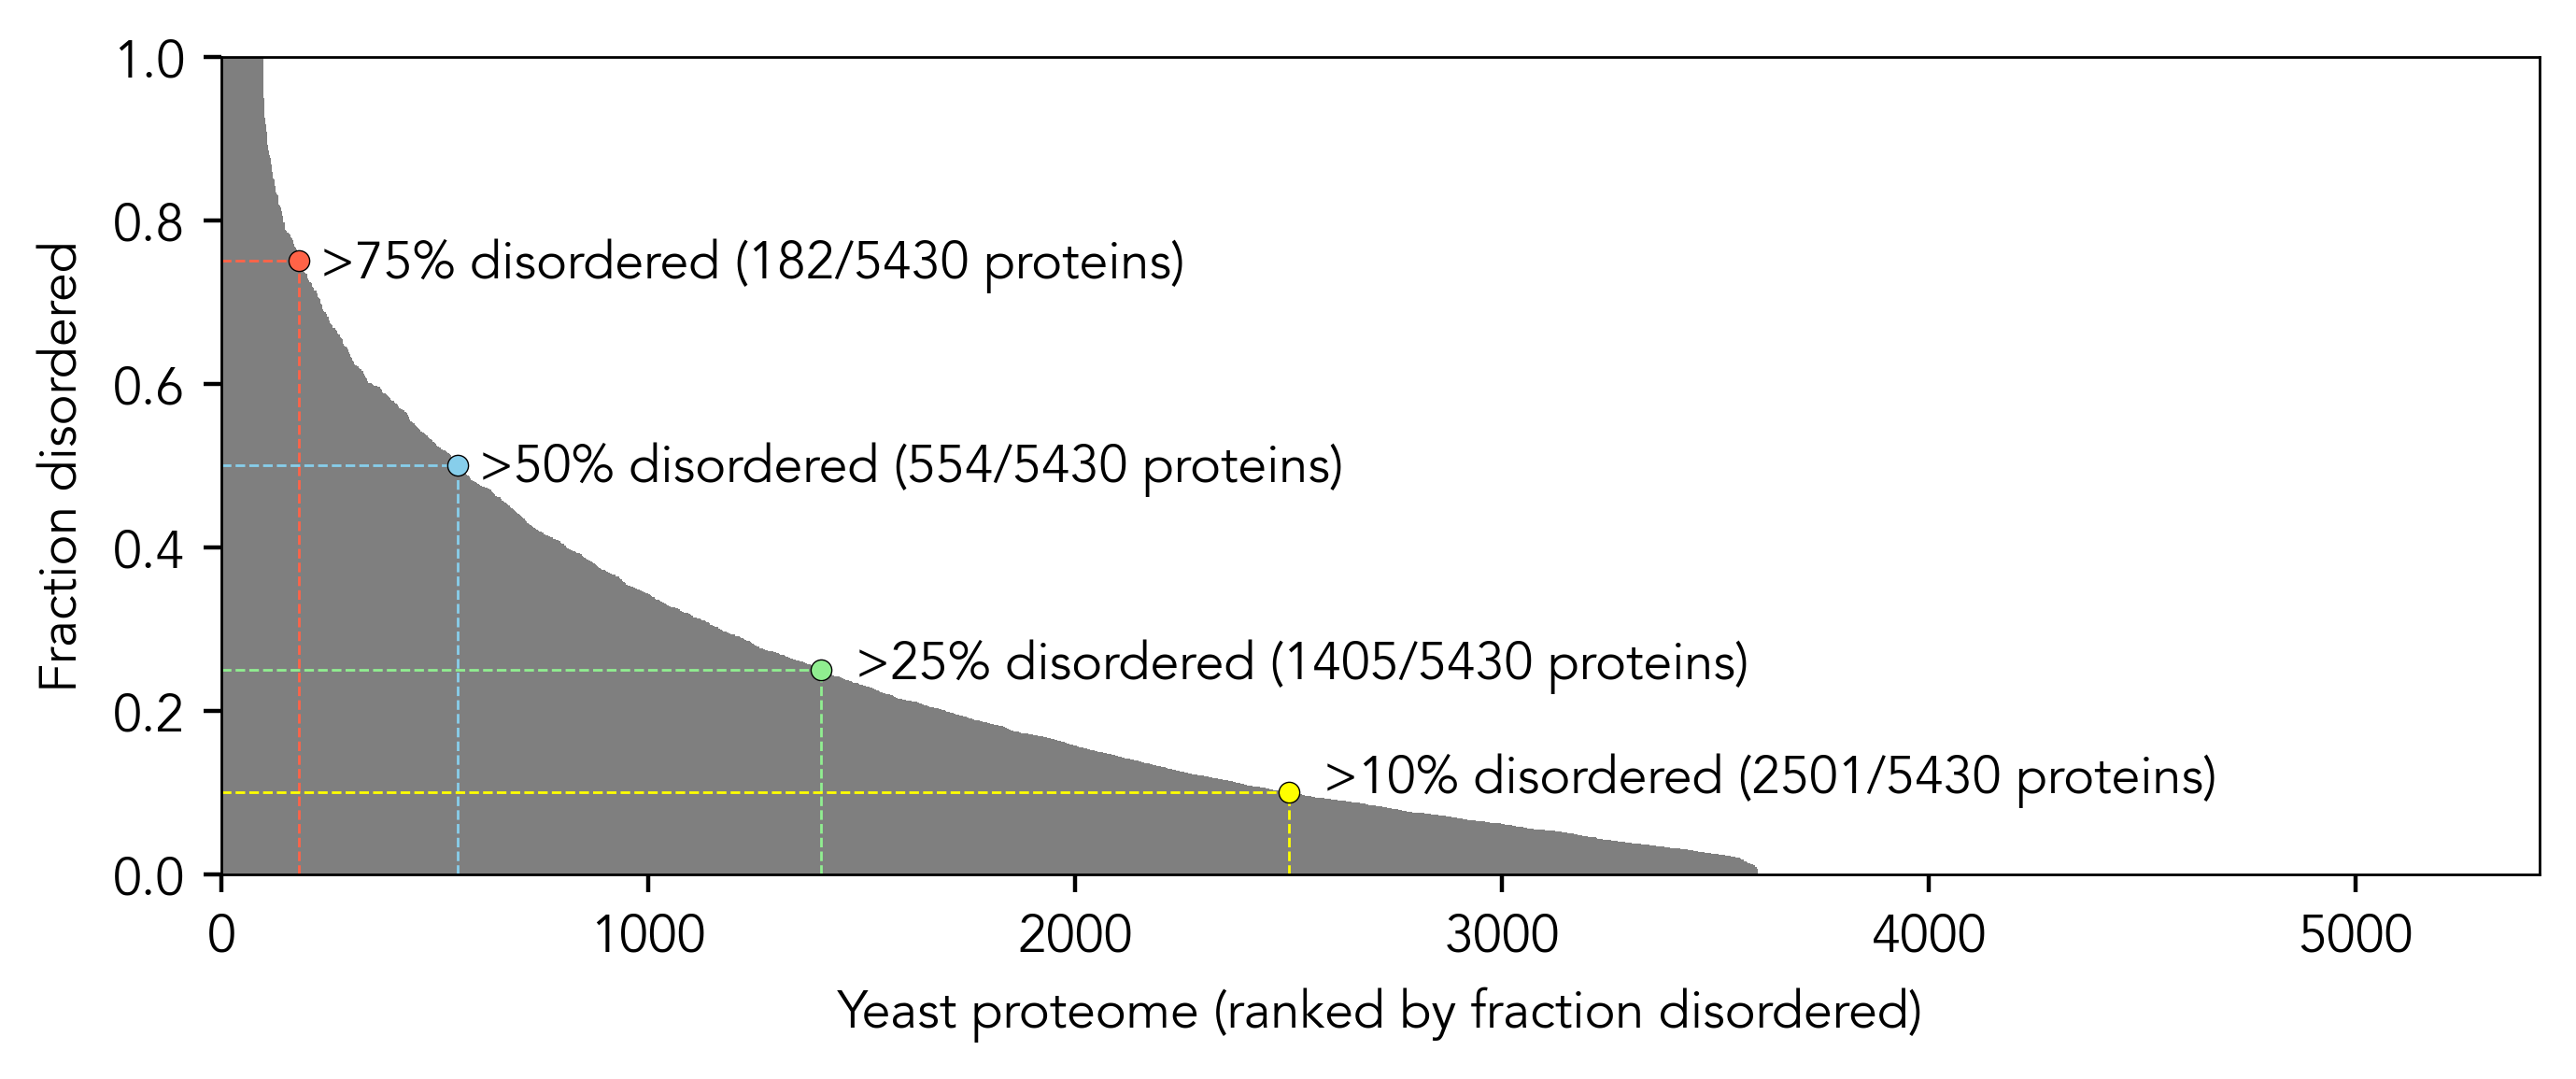

In [8]:
figure(num=None, figsize=(7, 3), dpi=200, facecolor='w', edgecolor='k')
idx = np.arange(0,len(fraction_disorder))
plt.bar(idx,np.sort(fraction_disorder)[::-1], width=1, color='k', alpha=0.5)
#plt.plot(idx,fraction_disorder, linewidth=0.8, color='k')
plt.xlabel('Yeast proteome (ranked by fraction disordered)')
plt.ylabel('Fraction disordered')

plt.plot([0,idx_75],[0.75,0.75],'--',linewidth=0.5, color='tomato')
plt.plot([idx_75,idx_75],[0,0.75],'--',linewidth=0.5, color='tomato')
plt.plot([idx_75],[0.75],'o',linewidth=0.5,ms=4,mec='k',mew=0.25, color='tomato')
plt.text(idx_75+50,0.73,f'>75% disordered ({idx_75}/{total_protein} proteins)')

plt.plot([0,idx_50],[0.5,0.5],'--',linewidth=0.5, color='skyblue')
plt.plot([idx_50,idx_50],[0,0.5],'--',linewidth=0.5, color='skyblue')
plt.plot([idx_50],[0.5],'o',linewidth=0.5,ms=4,mec='k',mew=0.25, color='skyblue')
plt.text(idx_50+50,0.48,f'>50% disordered ({idx_50}/{total_protein} proteins)')

plt.plot([0,idx_25],[0.25,0.25],'--',linewidth=0.5,color='lightgreen')
plt.plot([idx_25,idx_25],[0,0.25],'--',linewidth=0.5, color='lightgreen')
plt.plot([idx_25],[0.25],'o',color='lightgreen',linewidth=0.5,ms=4,mec='k',mew=0.25)
plt.text(idx_25+80,0.24,f'>25% disordered ({idx_25}/{total_protein} proteins)')

plt.plot([0,idx_10],[0.1,0.1],'--',linewidth=0.5, color='yellow')
plt.plot([idx_10,idx_10],[0,0.1],'--',linewidth=0.5, color='yellow')
plt.plot([idx_10],[0.1],'o',color='yellow',linewidth=0.5,ms=4,mec='k',mew=0.25)
plt.text(idx_10+80,0.1,f'>10% disordered ({idx_10}/{total_protein} proteins)')


plt.xlim([0,idx[-1]])
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('figures/disorder_in_yeast_proteome.pdf')


### Fraction of proteome with and IDR of length _n_ or longer
The next analysis asks what fraction of the yeast proteome has an IDR of length _n_ residues or longer

In [9]:
proteins_with_one_or_more_idrs = []
ts = np.arange(10,160,10)

for length_thresholds in ts:
    
    idr_count = 0
    for protein in yeast_proteome:
        for domain in protein.domains:
            if len(domain) > length_thresholds:
                idr_count = idr_count + 1
                break
                
    proteins_with_one_or_more_idrs.append(idr_count/len(yeast_proteome))
    

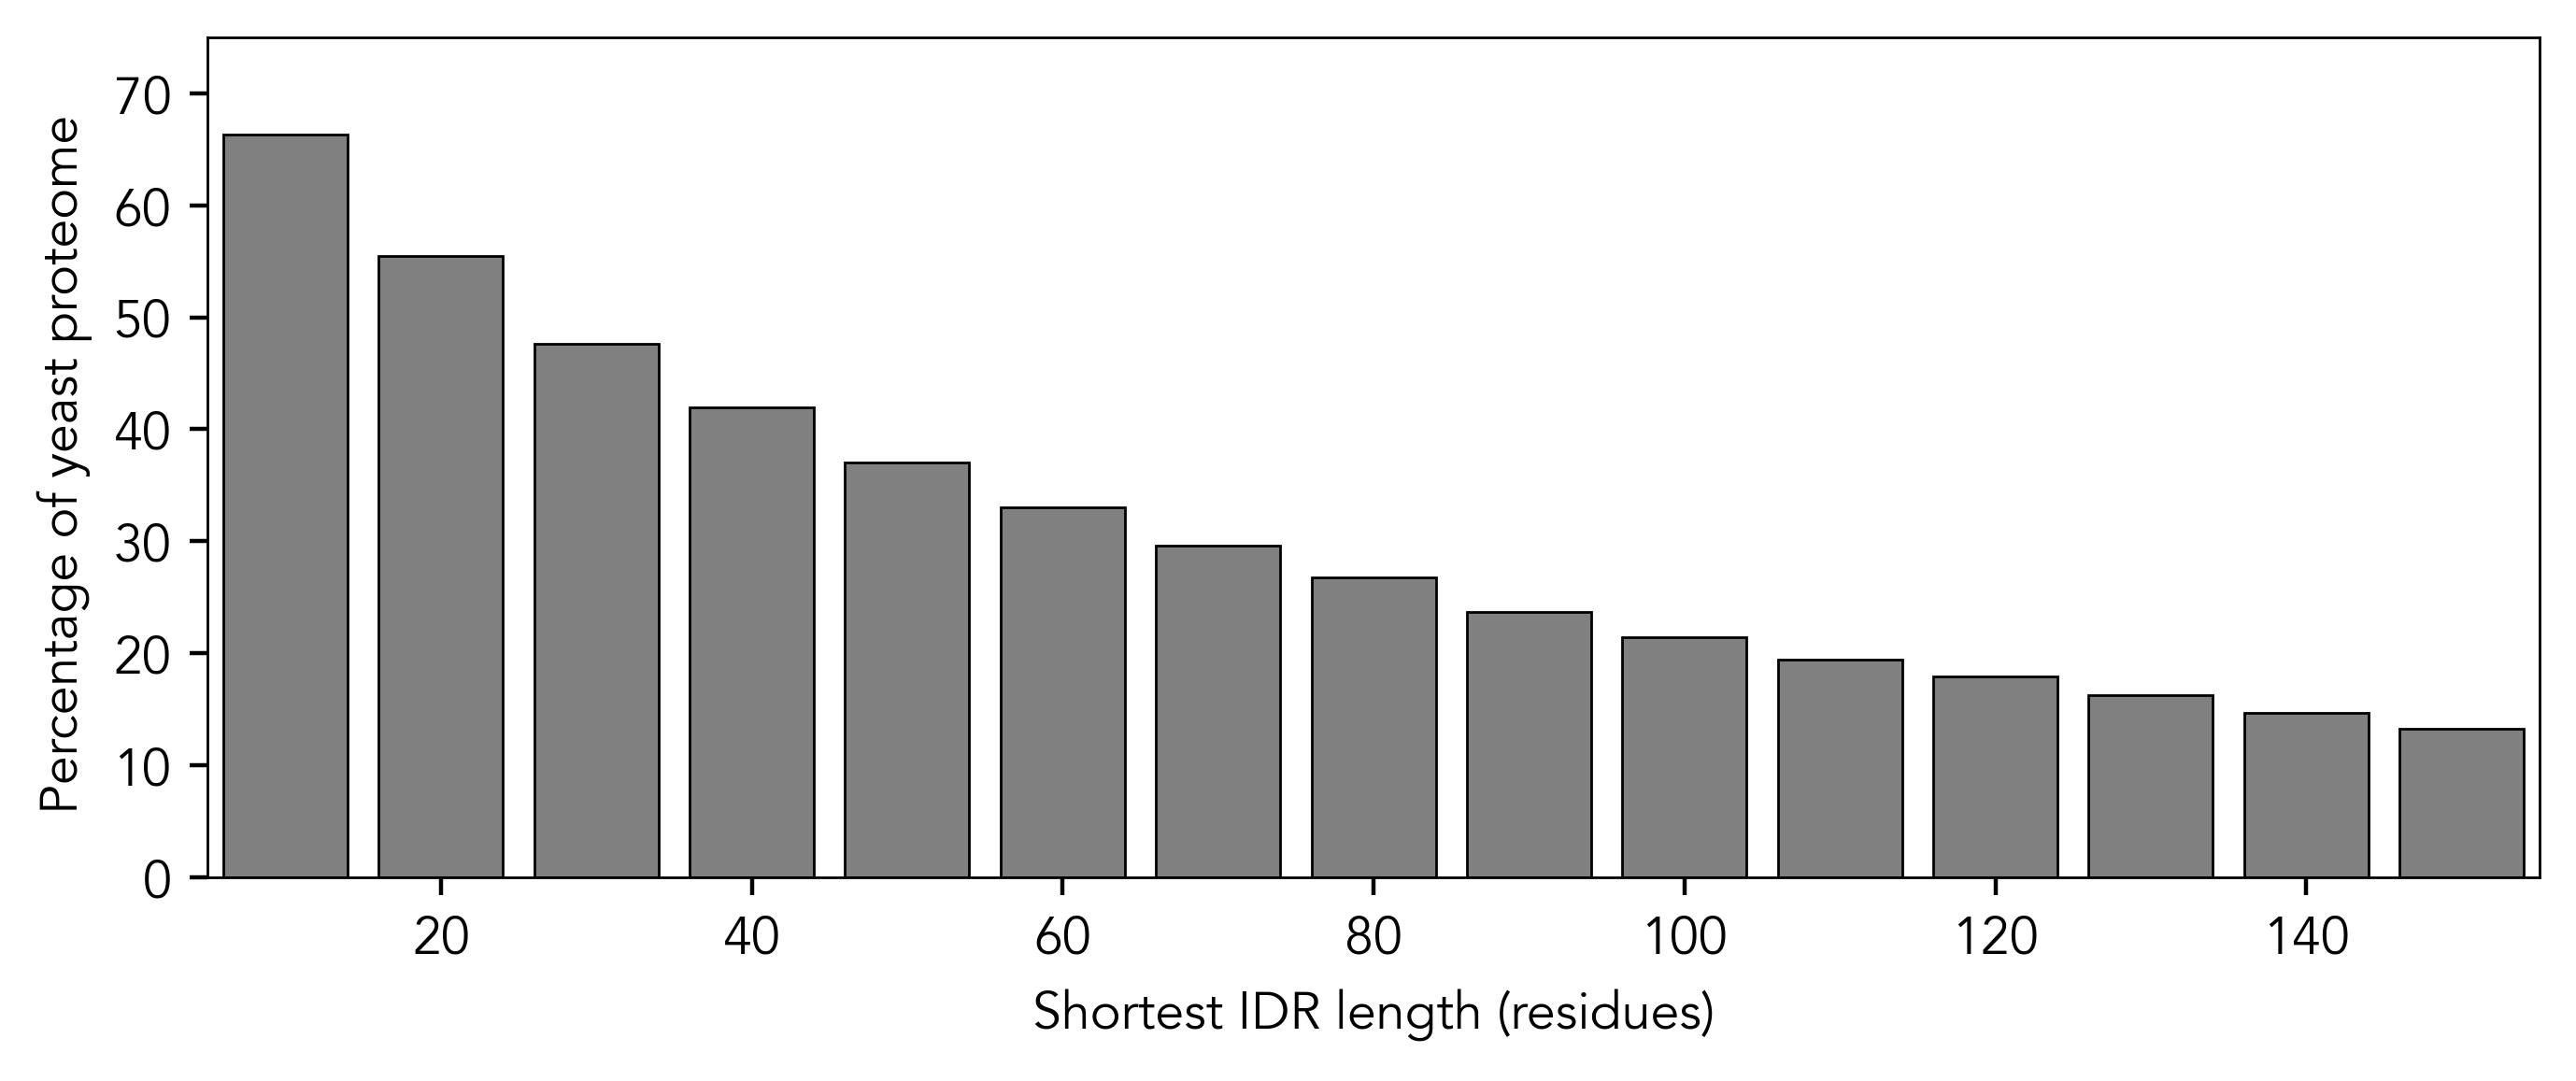

In [10]:
figure(num=None, figsize=(7, 3), dpi=200, facecolor='w', edgecolor='k')
plt.bar(ts,100*np.array(proteins_with_one_or_more_idrs), width=8, color='grey', edgecolor='k', linewidth=0.5)
plt.xlim([5,155])
plt.ylim([0,75])

plt.ylabel('Percentage of yeast proteome ')
plt.xlabel('Shortest IDR length (residues)')
plt.tight_layout()
plt.savefig('figures/percent_of_proteome_with_IDR_of_size.pdf')


### Fraction of residues in disordered regions
This analysis asks what fraction of residues across the yeast proteome fall into disordered regions vs. folded regions

In [11]:
count_disorder = 0
count_ordered = 0
for protein in yeast_proteome:
    local = 0
    for domain in protein.domains:
        local = local + len(domain)
    count_disorder = count_disorder + local
    count_ordered = count_ordered + (len(protein)-local)

total_count =  count_disorder +  count_ordered  

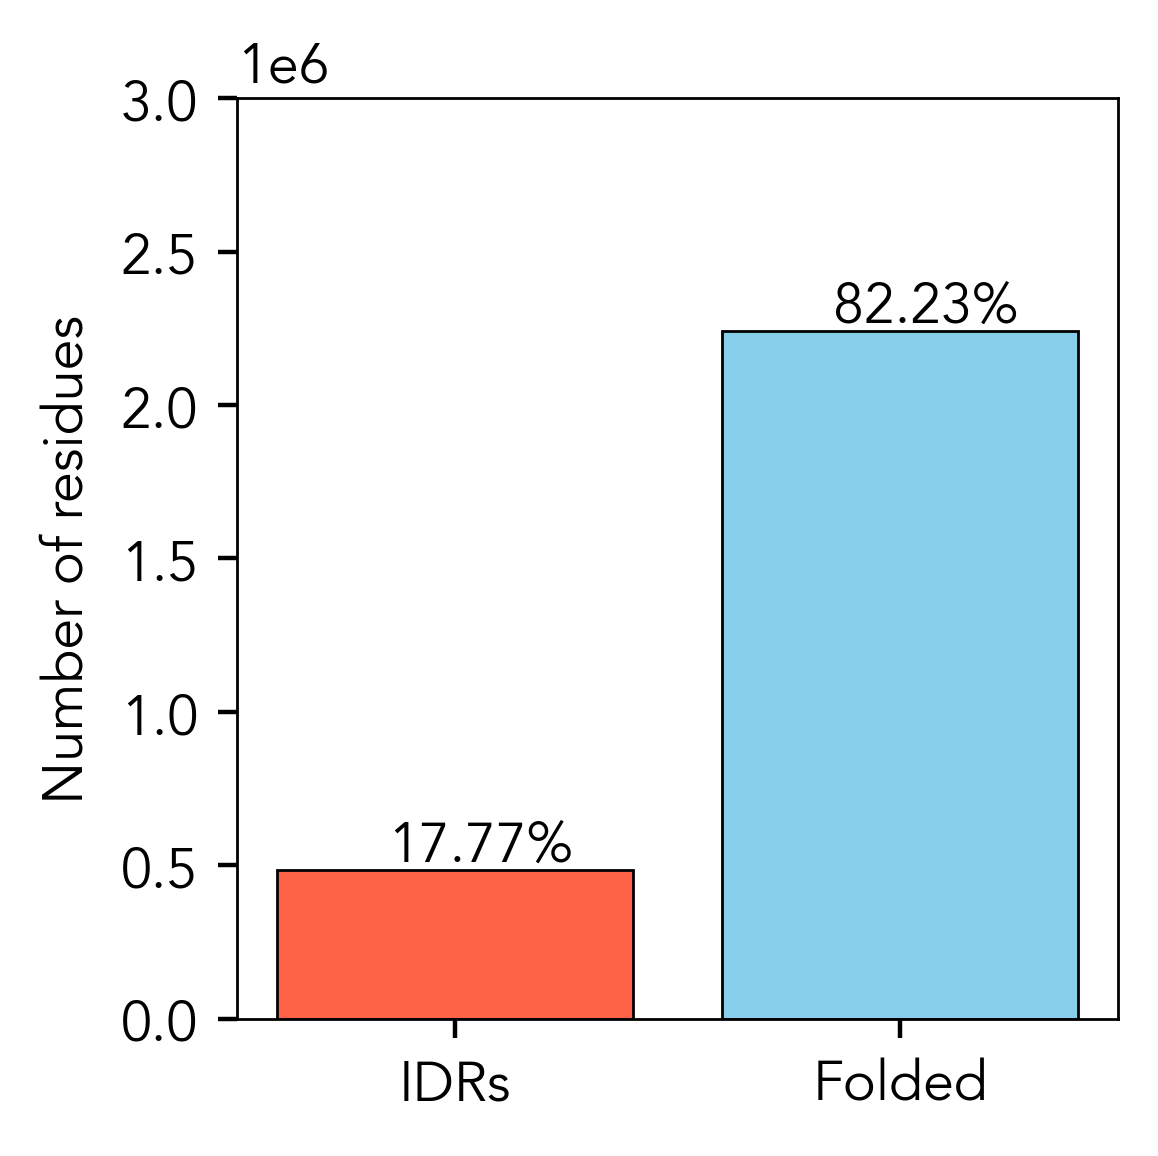

In [12]:
figure(num=None, figsize=(3, 3), dpi=200, facecolor='w', edgecolor='k')
plt.bar([1],[count_disorder], width=0.8, color='tomato',edgecolor='k',linewidth=0.5)
plt.bar([2],[count_ordered], width=0.8, color='skyblue',edgecolor='k',linewidth=0.5)
plt.ylim([0,3000000])
plt.ylabel('Number of residues')
plt.xticks([1,2],['IDRs','Folded'])
plt.text(0.85,count_disorder+30000, f'{100*round(count_disorder/total_count,4)}%')
plt.text(1.85,count_ordered+30000, f'{100*round(count_ordered/total_count,4)}%')

plt.tight_layout()
plt.savefig('figures/disordered_residues.pdf')


In [13]:
median_IDR_conservation = []
IDR_length = []
for protein in yeast_proteome:
    for domain in protein.domains:
        c = np.median(domain.get_track_values('conservation'))
        median_IDR_conservation.append(c)
        IDR_length.append(len(domain))



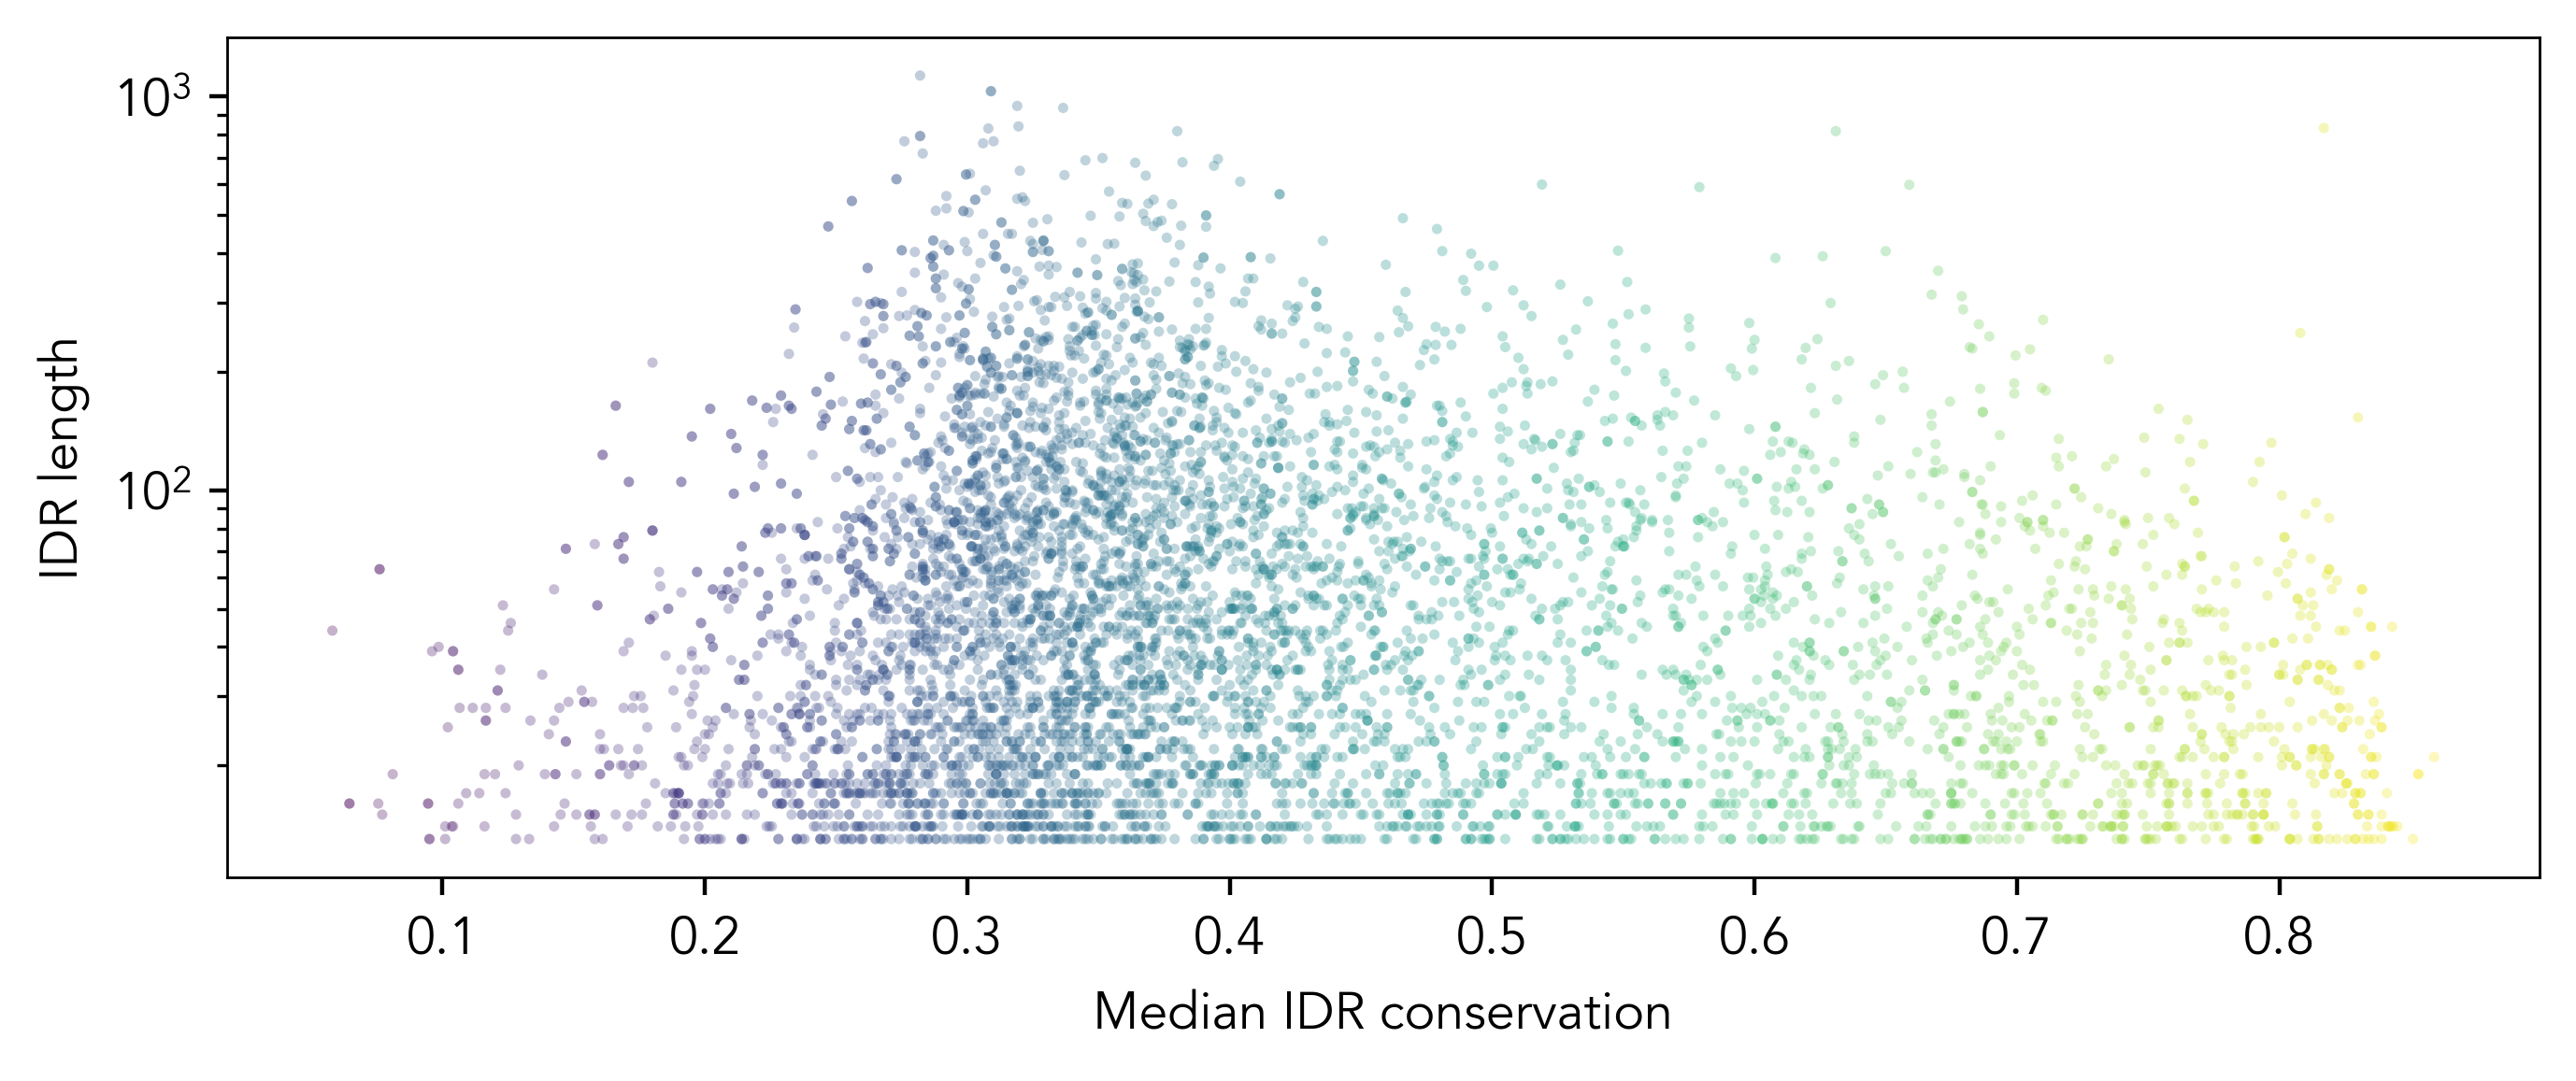

In [14]:
figure(num=None, figsize=(7, 3), dpi=200, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.scatter(median_IDR_conservation,IDR_length,c=median_IDR_conservation,alpha=0.3,linewidth=0,s=4, rasterized=True)

ax.set_yscale('log')
plt.ylabel('IDR length')
plt.xlabel('Median IDR conservation')

plt.tight_layout()
plt.savefig('figures/IDR_conservation_vs_length.pdf')


In [17]:
with open("output_data/YSN2UID.pkl", "rb") as f:
    YSN2UID = pickle.load(f)


In [19]:

IDRs_with_conservation = []
for protein in yeast_proteome:
    for domain in protein.domains:
        c = np.median(domain.get_track_values('conservation'))
        YSN = protein.name.split('_')[0]
        UID = YSN2UID[YSN]
        IDRs_with_conservation.append([YSN, UID, c, len(domain), domain.start, domain.end, domain.sequence])

IDRs_with_conservation = sorted(IDRs_with_conservation, key=lambda x: x[2], reverse=True)
with open('output_data/conserved_idrs.csv','w') as fh:
    fh.write('YSN, UniProt, median conservation, length, start, end, sequence \n')
    for l in IDRs_with_conservation:
        
        fh.write(f'{l[0]}, {l[1]}, {l[2]}, {l[3]}, {l[4]}, {l[5]},{l[6]}\n')

In [20]:
AA_conservation = {}
valid_AA = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'] 
for AA in valid_AA:
    AA_conservation[AA] = []


for protein in yeast_proteome:
    for domain in protein.domains:
        s = domain.sequence
        c = domain.get_track_values('conservation')
        for i in range(len(s)):
            s_val = s[i]
            c_val = c[i]
            AA_conservation[s_val].append(c_val)
        


In [21]:
SCORES=[]
for aa in valid_AA:
    SCORES.append(AA_conservation[aa])

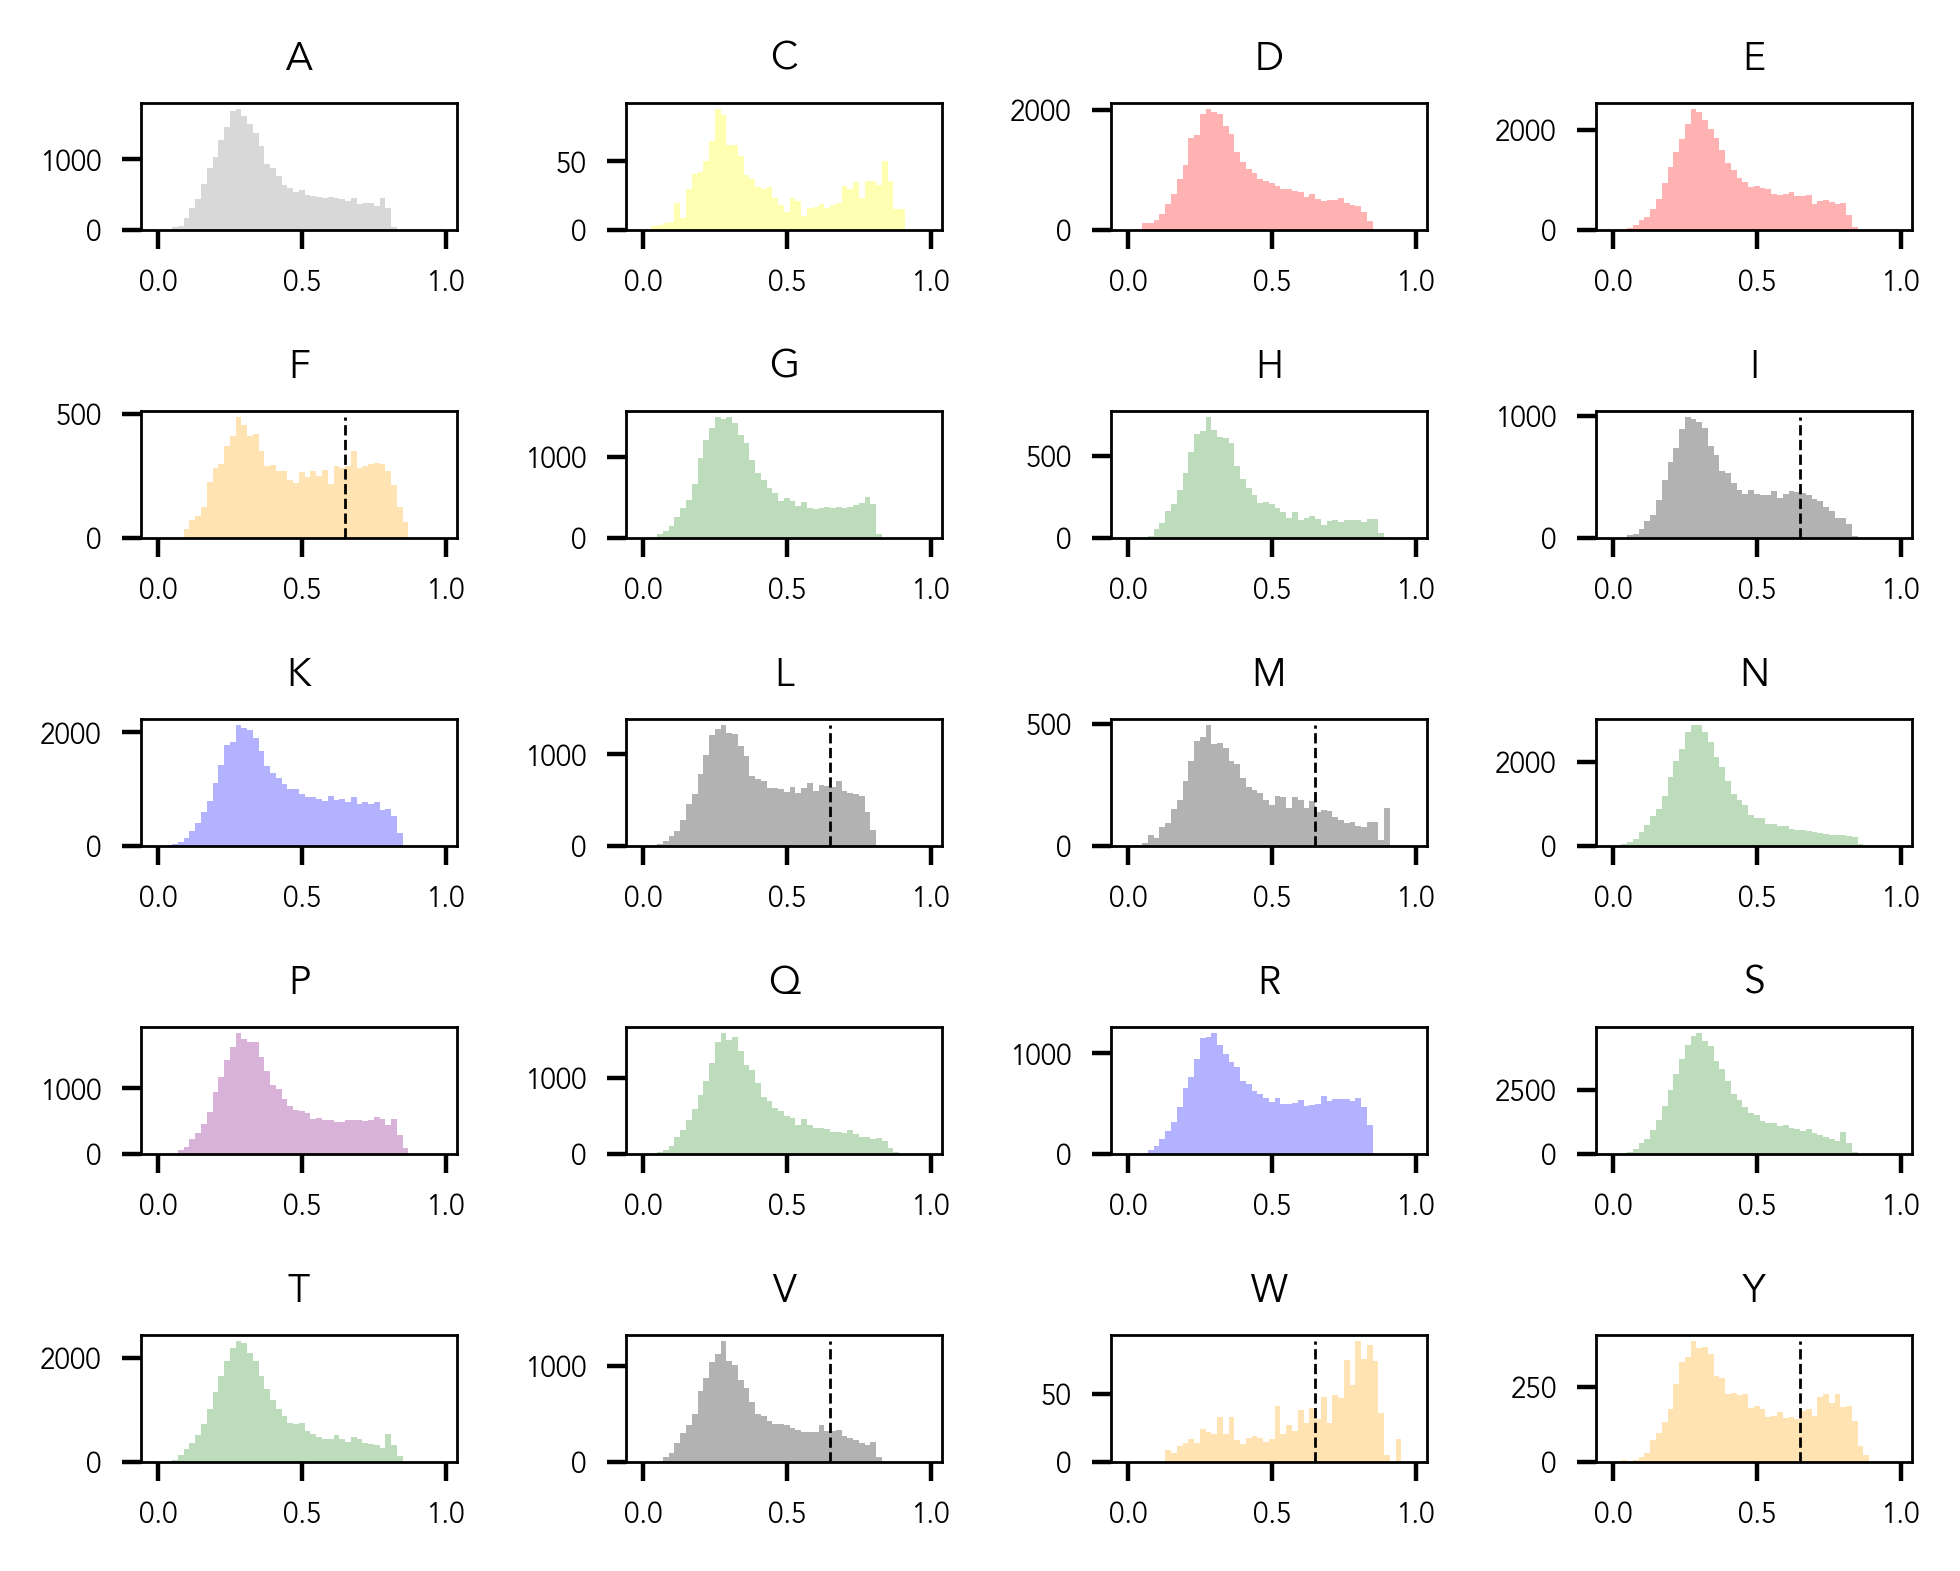

In [22]:
binsize=0.02
binz = np.arange(0,1+binsize,binsize)

color_mapping = {'A':'grey',
                 'C':'yellow',
                 'D': 'red',
                 'E': 'red',
                 'F': 'orange',
                 'G': 'forestgreen',
                 'H': 'forestgreen',
                 'I': 'black',
                 'K': 'blue',
                 'L': 'black',
                 'M': 'black',
                 'N': 'forestgreen',
                 'P': 'purple',
                 'Q': 'forestgreen',
                 'R': 'blue',
                 'S': 'forestgreen',
                 'T': 'forestgreen',                 
                 'V': 'black',
                 'W': 'orange',
                 'Y': 'orange'}
                 

fig, axs = plt.subplots(5, 4, figsize=(5,4), dpi=200)

fig.tight_layout()
for i in range(0,5):
    for j in range(0,4):
        aa_selector = (i*4)+j
        aa = valid_AA[aa_selector]
        [a,b] = np.histogram(AA_conservation[aa],bins=binz)
        axs[i, j].bar(b[:-1], a, width=binsize, alpha=0.3, color=color_mapping[aa])
        if aa in ['Y','L','M','I','V','F','W']:
            axs[i, j].plot([0.65,0.65],[0,max(a)],'--k',linewidth=0.5)
        axs[i, j].tick_params(axis='both', which='major', labelsize=5)
        axs[i,j].set_title(aa,fontsize=7)
        
plt.savefig('figures/per_residue_conservation_histo.pdf')



In [23]:
conserved_regions_count = []
for thresholds in ['0.3','0.4','0.5','0.6','0.7']:
    with open(f'output_data/conserved_subsequences_disorder_thresh_{thresholds}.csv','r') as fh:
        content = fh.readlines()
    conserved_regions_count.append(len(content))

In [24]:
conserved_regions_count

[5173, 4768, 3166, 1705, 884]

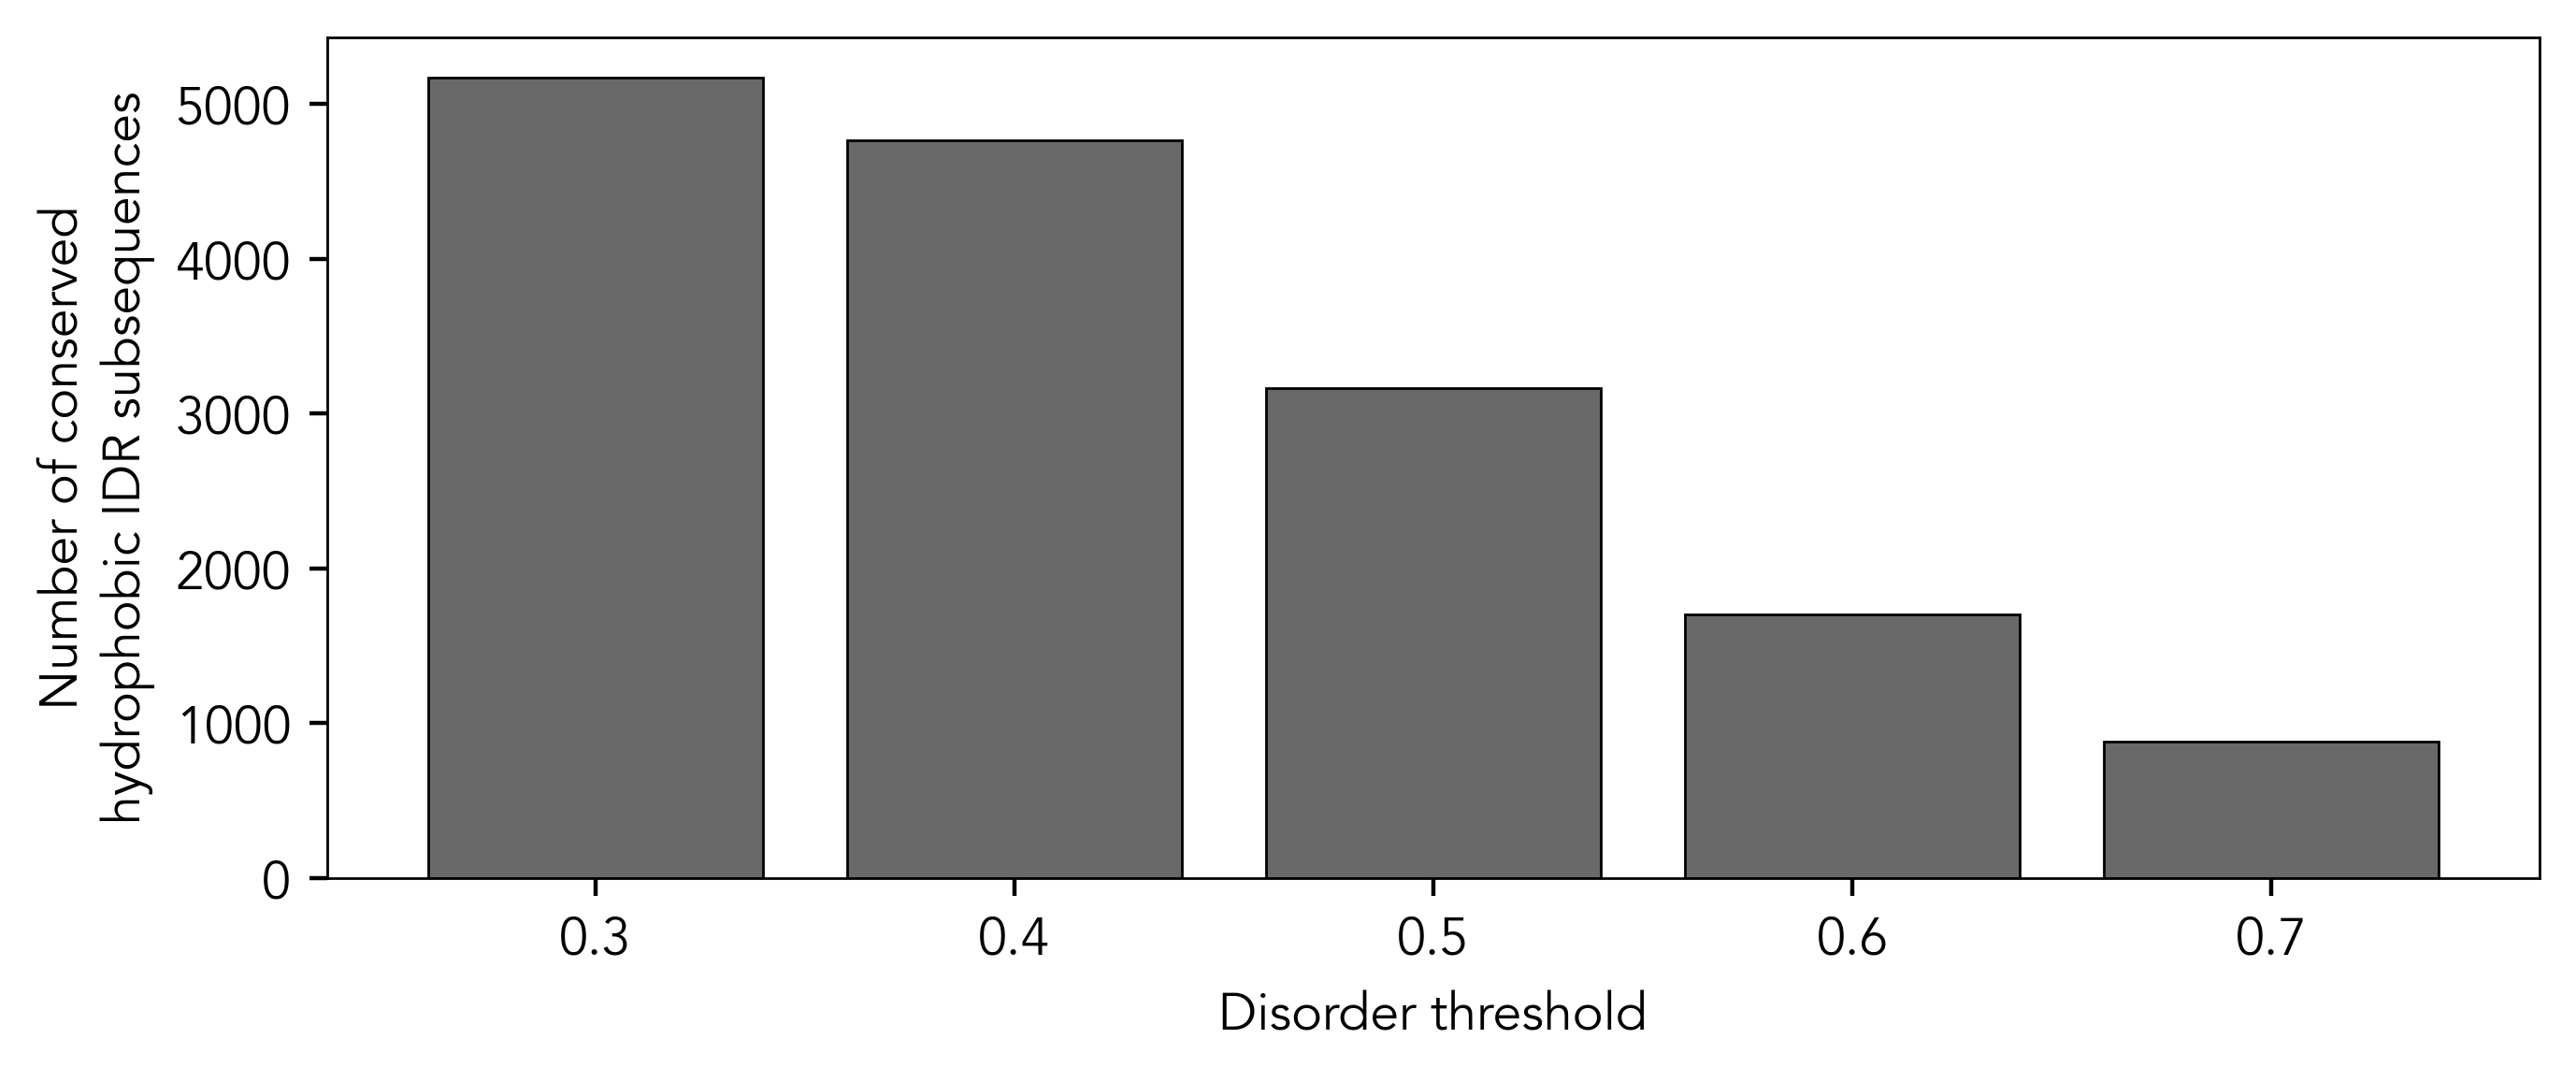

In [25]:
figure(num=None, figsize=(7, 3), dpi=200, facecolor='w', edgecolor='k')
plt.bar([0.3,0.4,0.5,0.6,0.7], conserved_regions_count, width=0.08, color='dimgrey', edgecolor='k', linewidth=0.5)

plt.ylabel('Number of conserved\nhydrophobic IDR subsequences')
plt.xlabel('Disorder threshold')
plt.tight_layout()
plt.savefig('figures/conserved_subsequences.pdf')


### Histogram of conservation scores


In [26]:
all_cons = []
disorder_cons = []
for protein in yeast_proteome:
    all_cons.extend(protein.get_track_values('conservation'))
    
    for domain in protein.domains:
        if domain.domain_type == 'IDR':
            disorder_cons.extend(domain.get_track_values('conservation'))
    

In [27]:
disorder_cons.sort()

In [28]:
cutoff=0.65
cutoff_percentile = np.where(np.array(disorder_cons) == cutoff)[0][0]/len(disorder_cons)
print(f'Residues in IDRs with a cutoff of {cutoff} are more conserved than {round(cutoff_percentile*100,1)}% of residues in all IDRs')

Residues in IDRs with a cutoff of 0.65 are more conserved than 85.6% of residues in all IDRs


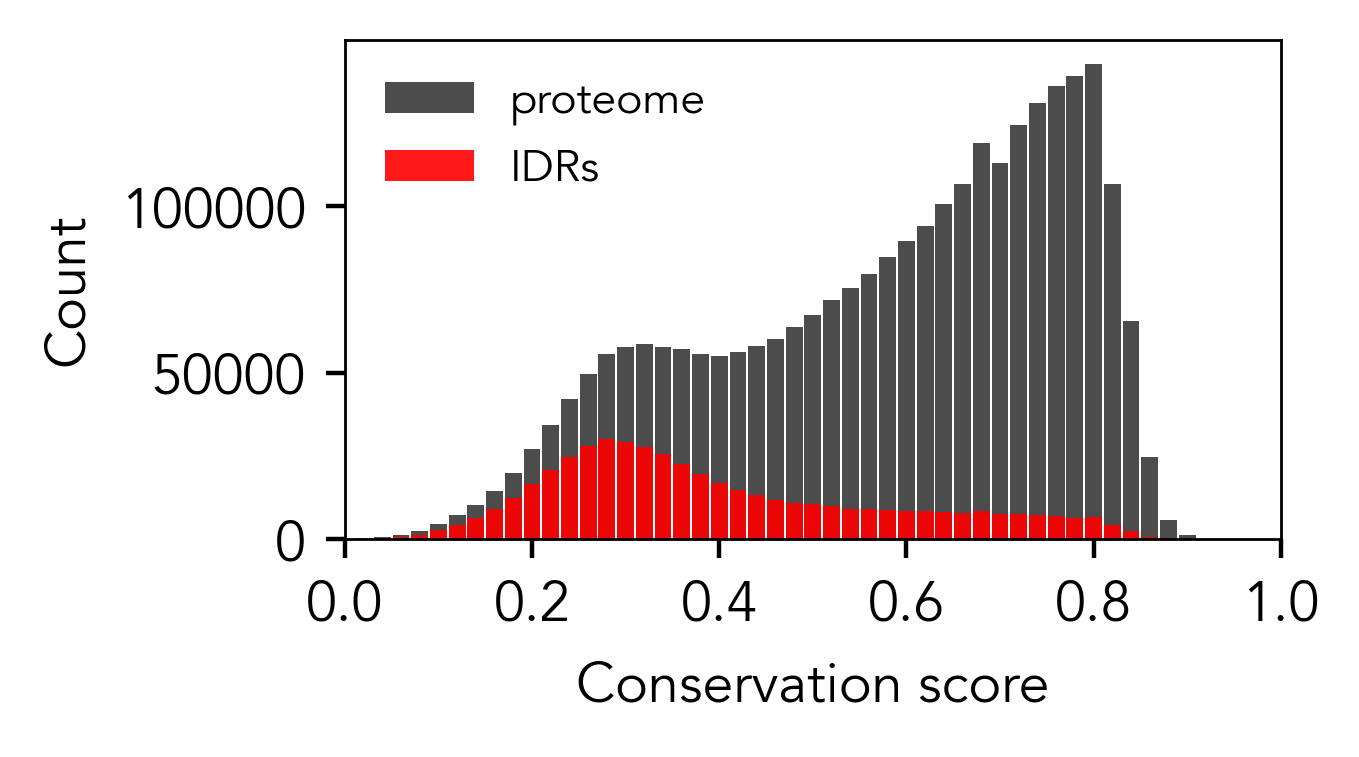

In [29]:
bw=0.02
bins = np.arange(0,1+bw,bw)
X = np.histogram(all_cons, bins=bins)
Z = np.histogram(disorder_cons, bins=bins)
figure(num=None, figsize=(3.5,2), dpi=200, facecolor='w', edgecolor='k')
plt.bar(X[1][:-1],X[0],width=bw*0.9, color='k', alpha=0.7,label='proteome')
plt.bar(Z[1][:-1],Z[0],width=bw*0.9, color='r', alpha=0.9,label='IDRs')
plt.xlim([0,1])
plt.legend(fontsize=8, frameon=False)
plt.xlabel('Conservation score')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('figures/conservation_histogram.pdf')
plt.savefig('figures/conservation_histogram.png')

### Determine conserved IDR regions in essential vs. non-essential

In [31]:
disorder_thresh = 0.7
local_proteome = fasta.fasta_to_proteome('../figure_1/data/yeast_sequence_dataset.fasta',use_header_as_unique_ID=True)
interfaces.si_domains.add_domains_from_file(local_proteome, f'output_data/SHPRD_conserved_subsequences_disorder_thresh_{disorder_thresh}.tsv')
interfaces.si_protein_attributes.add_protein_attributes_from_file(local_proteome,'../figure_1/data/essential_proteins_SHPRD.tsv')
    
    

In [32]:

essential_hits = 0
non_essential_hits = 0

essential_proteins_count = 0
non_essential_proteins_count = 0

for protein in local_proteome:
    if 'essential_protein' in protein.attributes:
        essential_proteins_count = essential_proteins_count + 1
        if len(protein.domains) > 0:
            essential_hits = essential_hits + 1
    else:
        non_essential_proteins_count = non_essential_proteins_count + 1
        if len(protein.domains) > 0:
            non_essential_hits = non_essential_hits + 1

        
    
true_essential_fract = essential_hits/essential_proteins_count
true_nonessential_fract = non_essential_hits/non_essential_proteins_count
    

In [33]:
local_proteins = local_proteome.proteins
fract_essential = []
fract_nonessential = []

for br in range(1000):
    random.shuffle(local_proteins)
    
    
    essential_hits = 0
    non_essential_hits = 0

    essential_proteins_count = 0
    non_essential_proteins_count = 0


    for protein_idx in local_proteins[0:500]:
        protein = local_proteome.protein(protein_idx)
        
        if 'essential_protein' in protein.attributes:
            essential_proteins_count = essential_proteins_count + 1
            if len(protein.domains) > 0:
                essential_hits = essential_hits + 1
        else:
            non_essential_proteins_count = non_essential_proteins_count + 1
            if len(protein.domains) > 0:
                non_essential_hits = non_essential_hits + 1
                
                
    fract_essential.append(essential_hits/essential_proteins_count)
    fract_nonessential.append(non_essential_hits/non_essential_proteins_count)



In [34]:
stats.ttest_ind(fract_essential,fract_nonessential,equal_var=False)

TtestResult(statistic=np.float64(61.90933353967124), pvalue=np.float64(0.0), df=np.float64(1368.8628389621088))

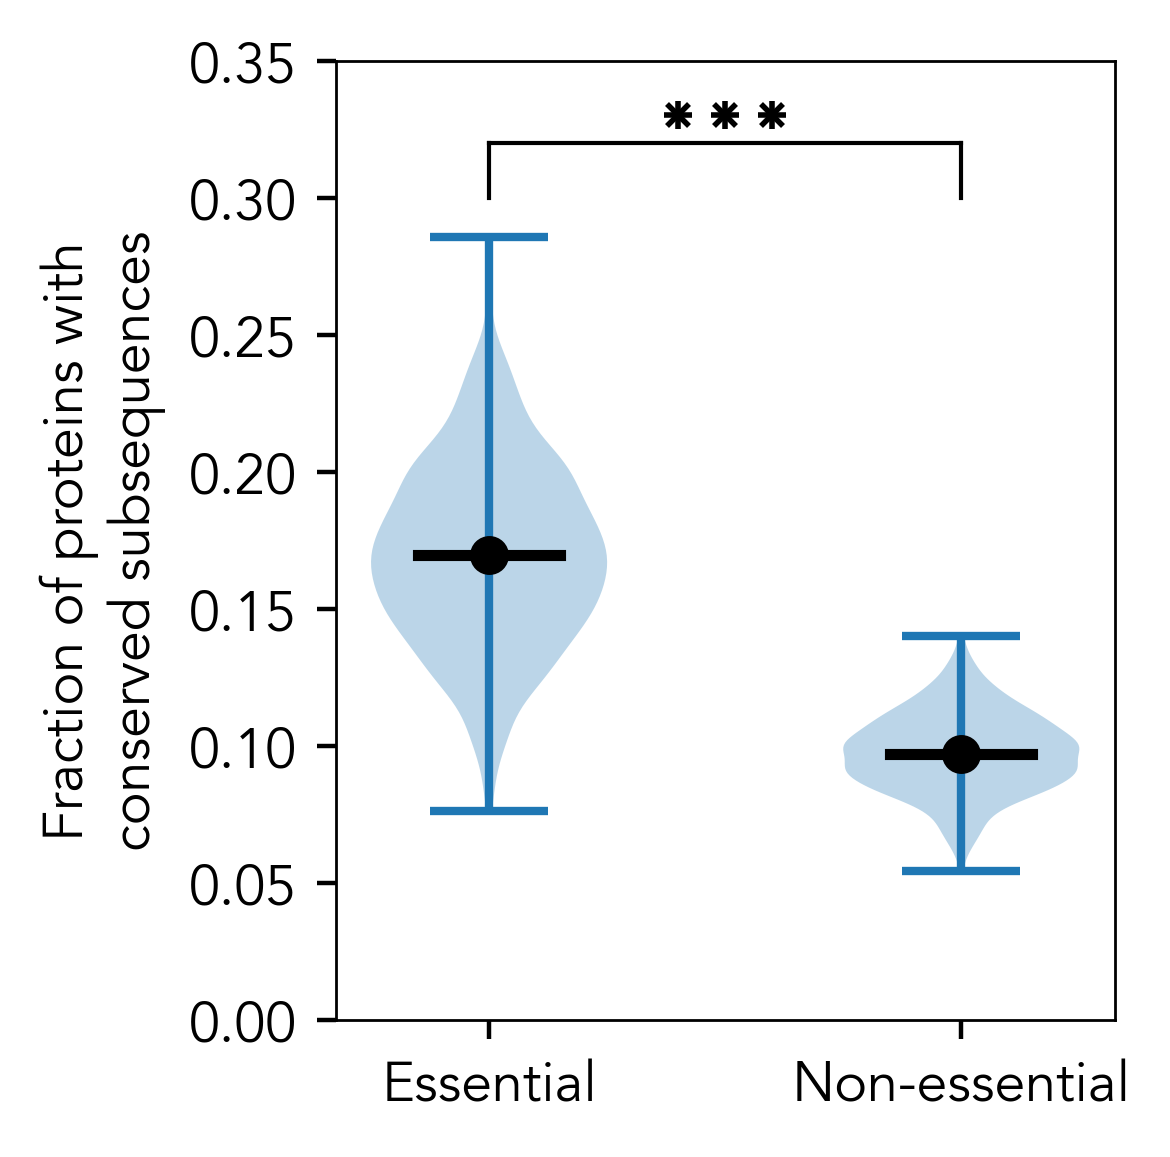

In [35]:
figure(num=None, figsize=(3, 3), dpi=200, facecolor='w', edgecolor='k')
plt.violinplot([fract_essential,fract_nonessential])
plt.ylabel('Fraction of proteins with\nconserved subsequences')
plt.xticks([1,2],['Essential','Non-essential'])

plt.plot([0.85,1.15],[true_essential_fract,true_essential_fract],'-k', linewidth=2)
plt.plot([1],[true_essential_fract],'ok', linewidth=2)

plt.plot([1.85,2.15],[true_nonessential_fract,true_nonessential_fract],'-k', linewidth=2)
plt.plot([2],[true_nonessential_fract],'ok', linewidth=2)

# significance lines
plt.plot([1,1],[0.30,0.32],'-k',linewidth=0.75)
plt.plot([1,2],[0.32,0.32],'-k',linewidth=0.75)
plt.plot([2,2],[0.30,0.32],'-k',linewidth=0.75)
plt.plot([1.4,1.5,1.6],[0.33,0.33,0.33],'xk',linewidth=0.25, ms=4)
plt.plot([1.4,1.5,1.6],[0.33,0.33,0.33],'+k',linewidth=0.25, ms=5)


plt.ylim([0,0.35])
plt.tight_layout()
plt.savefig('figures/essential_vs_nonessentail_conserved_binding_motifs.pdf')

